## Automatic Extraction Method
Here the objective is to automatically extract rules from pyhard metadata that can predict if an instance is hard or easy for a given classifier using that instances metafeatures.

Generate metadata, algorithm_bin and beta_easy for train, test and validation data

In [11]:
import preprocess as pp

# Directory with the CSV File with data for original features
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/compas"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/compas_no_race"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/covid/internacao"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/credit-g"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/glass"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/iris"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/pima_diabetes"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/cifar/people"
direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/cifar/vehicles"

In [2]:
# Generate metadata, algorithm_bin and beta_easy for train and test data
pp.create_isa_datasets(direc)

100%|██████████| 20/20 [00:13<00:00,  1.45trial/s, best loss: -0.9316363636363637]
--- 881.3828377723694 seconds ---


Read .csv files with original data, metadata, algorithm_bin and beta_easy

In [12]:
import pandas as pd

df_original = pd.read_csv(f'{direc}/original.csv')
df_metadata = pd.read_csv(f'{direc}/metadata.csv')
df_algorithm_bin = pd.read_csv(f'{direc}/algorithm_bin.csv')
df_beta_easy = pd.read_csv(f'{direc}/beta_easy.csv')

#remove algorithms from metafeature sets
algos = ['algo_bagging', 'algo_gradient_boosting', 'algo_logistic_regression', 
     'algo_mlp', 'algo_random_forest', 'algo_svc_linear', 'algo_svc_rbf']

for a in algos:
    del df_metadata[a]
    

# join algorithm bin and beta easy for train, validation and test data
df_performance = df_algorithm_bin.assign(IsBetaEasy = df_beta_easy['IsBetaEasy'])

Split into train, validation and test

In [13]:
import preprocess as pp

# Create train, validation and test datasets
df_train_aux, df_test  = pp.split_sets(X = df_original.iloc[: , :-1], 
                                       y = df_original.iloc[: , -1])

df_train, df_val  = pp.split_sets(X = df_train_aux.iloc[: , :-1], 
                                  y = df_train_aux.iloc[: , -1])

# get indices
train_idx = df_train.index
val_idx = df_val.index
test_idx = df_test.index

#Separate sets
df_train = df_original.iloc[train_idx]
df_val = df_original.iloc[val_idx]
df_test = df_original.iloc[test_idx]

df_metadata_train = df_metadata.iloc[train_idx]
df_metadata_val = df_metadata.iloc[val_idx]
df_metadata_test = df_metadata.iloc[test_idx]

df_algorithm_bin_train = df_algorithm_bin.iloc[train_idx]
df_algorithm_bin_val = df_algorithm_bin.iloc[val_idx]
df_algorithm_bin_test = df_algorithm_bin.iloc[test_idx]

df_beta_easy_train = df_beta_easy.iloc[train_idx]
df_beta_easy_val = df_beta_easy.iloc[val_idx]
df_beta_easy_test = df_beta_easy.iloc[test_idx]

Let's verify if we have unbalanced classes in the beta easy train dataset and if so oversample the minority class

In [15]:
from imblearn.over_sampling import RandomOverSampler 

print(df_beta_easy_train.value_counts(), "\n")

ros = RandomOverSampler(sampling_strategy='minority', random_state=42)

X_res, y_res = ros.fit_resample(df_train.to_numpy(), df_beta_easy_train.IsBetaEasy.to_numpy())

print(pd.DataFrame(y_res).value_counts(), "\n")


# df_train_balanced = df_train.iloc[ros.sample_indices_,]
# df_metadata_train_balanced = df_metadata_train.iloc[ros.sample_indices_,]
# df_beta_easy_train_balanced = df_beta_easy_train.iloc[ros.sample_indices_,]

df_train_balanced = df_train
df_metadata_train_balanced = df_metadata_train
df_beta_easy_train_balanced = df_beta_easy_train

IsBetaEasy
1             1080
0              145
dtype: int64 

0    1080
1    1080
dtype: int64 



Let's tune the hyperparameters merge and drop:

In [16]:
import numpy as np
import autoextractionmethod as aem

import time
start_time = time.time()

start_merge = 0
stop_merge = 0.01
step_merge = 0.002

start_drop = 0
stop_drop = 0.25
step_drop = 0.05

merge_space = np.arange(start_merge, stop_merge, step_merge)
drop_space = np.arange(start_drop, stop_drop, step_drop)

df_f1 = aem.tune_hyper_params(merge_space, 
                                    drop_space, 
                                    df_train_balanced, 
                                    df_metadata_train_balanced, 
                                    #df_performance_train,
                                    df_beta_easy_train_balanced,
                                    df_metadata_val, 
                                    #df_performance_val,
                                    df_beta_easy_val,
                                    direc)


print("--- %s seconds ---" % (time.time() - start_time))

percent merge: 0.000, percent drop: 0.00
percent merge: 0.000, percent drop: 0.05
percent merge: 0.000, percent drop: 0.10
percent merge: 0.000, percent drop: 0.15
percent merge: 0.000, percent drop: 0.20
percent merge: 0.002, percent drop: 0.00
percent merge: 0.002, percent drop: 0.05
percent merge: 0.002, percent drop: 0.10
percent merge: 0.002, percent drop: 0.15
percent merge: 0.002, percent drop: 0.20
percent merge: 0.004, percent drop: 0.00
percent merge: 0.004, percent drop: 0.05
percent merge: 0.004, percent drop: 0.10
percent merge: 0.004, percent drop: 0.15
percent merge: 0.004, percent drop: 0.20
percent merge: 0.006, percent drop: 0.00
percent merge: 0.006, percent drop: 0.05
percent merge: 0.006, percent drop: 0.10
percent merge: 0.006, percent drop: 0.15
percent merge: 0.006, percent drop: 0.20
percent merge: 0.008, percent drop: 0.00
percent merge: 0.008, percent drop: 0.05
percent merge: 0.008, percent drop: 0.10
percent merge: 0.008, percent drop: 0.15
percent merge: 0

Let's plot the f1 scores to see if the search space is giving good results

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

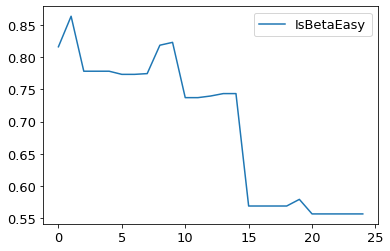

In [17]:
import matplotlib.pyplot as plt

plt.figure()

df_f1.plot()

Extract rules using the automatic extraction method

In [18]:
import autoextractionmethod as aem

import time
start_time = time.time()

df_best = pd.read_csv(f'{direc}/best_hyperparameters.csv')
df_best.rename(index={0: 'f1', 1:'merge', 2:'drop'}, inplace=True)

# extract the rule intervals using the train data
dict_E, dict_H = aem.auto_extraction(df_train_balanced, 
                                     df_metadata_train_balanced, 
                                     #df_performance_train,
                                     df_beta_easy_train_balanced,
                                     df_best.loc['drop'], 
                                     df_best.loc['merge'])

# Easy behavior rules
dict_easy_rules = aem.simple_rules(dict_E, len(df_train_balanced))

# Hard behavior rules
dict_hard_rules = aem.simple_rules(dict_H, len(df_train_balanced))

# Let's keep the metafeatures that are present in both easy and hard intervals for a given performance measure
#dict_easy_rules, dict_hard_rules = aem.common_rules(dict_easy_rules, dict_hard_rules)

# Let's predict the performance of the test datasets using the rules
# We also obtain the Positive Rule Disjunction (PRD) and Negative Rule Disjunction (NRD)  
# The disjunctive combination of all the simple positive rules or all the simple negative 
# rules is used to obtain a single positive and single negative rule.

dict_pred = aem.predict(#df_performance_train,
                        df_beta_easy_test,
                        df_metadata_test, 
                        dict_easy_rules, 
                        dict_hard_rules)

print("--- %s seconds ---" % (time.time() - start_time))

--- 5.613038539886475 seconds ---


In [19]:
aem.display_side_by_side(dict_easy_rules["IsBetaEasy"] ,dict_hard_rules["IsBetaEasy"], titles=['Easy','Hard'])

# Latex tables
#print(dict_easy_rules["IsBetaEasy"].drop(columns = 'Index').round(2).to_latex(index=False))  
#print(dict_hard_rules["IsBetaEasy"].drop(columns = 'Index').round(2).to_latex(index=False))  


,Metafeature,Index,Interval,Support
0,feature_CL,"[430, 530]","[0.107624, 0.118588]",0.08
1,feature_DCP,"[224, 481]","[0.037037, 0.083612]",0.21
2,feature_F1,"[854, 917]","[0.972534, 0.974121]",0.05
3,feature_Harmfulness,"[387, 471]","[0.0, 0.0]",0.07
4,feature_LSC,"[0, 500]","[0.480962, 0.9499]",0.41
5,feature_N1,"[960, 1046]","[0.0, 0.333333]",0.07
6,feature_N2,"[103, 323]","[0.389976, 0.442626]",0.18
7,feature_Usefulness,"[0, 337]","[0.386, 0.894]",0.28
8,feature_kDN,"[288, 589]","[0.0, 0.0]",0.25
,Metafeature,Index,Interval,Support


Let's evaluate the performance of the ruleset

Weighted F1 Score Train: 0.86
Weighted F1 Score Test: 0.87
--- 0.243147611618042 seconds ---


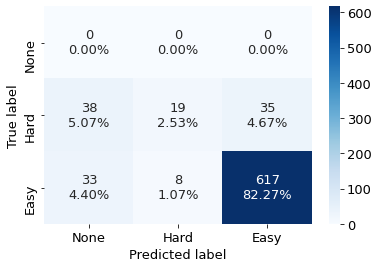

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import cf_matrix as cm
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import time

start_time = time.time()


# Change plot font size and update to save as latex
#matplotlib.use("png")
plt.rcParams.update({
    'font.size': 13
})


# Let's get the performance names for the current dataset
#performance_names = list(df_performance_test.columns)

performance = "IsBetaEasy"

dict_pred[performance].PRD = dict_pred[performance].PRD == 1
dict_pred[performance].NRD = dict_pred[performance].NRD == 1

dict_pred[performance]['PRD_not_NRD'] = dict_pred[performance].PRD & ~dict_pred[performance].NRD
dict_pred[performance]['NRD_not_PRD'] = ~dict_pred[performance].PRD & dict_pred[performance].NRD

# Which rules are used to classify easy and hard instances
mask1 = dict_pred[performance].PRD_not_NRD == True
mask2 = dict_pred[performance].NRD_not_PRD == True

dict_pred[performance]['Final'] = [-1] * len(df_metadata_test)

dict_pred[performance].loc[mask2, ('Final')] = 0
dict_pred[performance].loc[mask1, ('Final')] = 1

matrix = confusion_matrix(df_beta_easy_test[performance], dict_pred[performance].Final)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['None', 'Hard', 'Easy']
    
# Get direc name
direc_name = os.path.basename(direc)
    
cm.make_confusion_matrix(matrix, 
                  group_names=labels,
                  categories=categories, 
                  cmap='Blues',
                  sum_stats=False
                        )

# f1 score
f1 = f1_score(df_beta_easy_test, 
               dict_pred["IsBetaEasy"].Final, 
               average='weighted')

print(f"Weighted F1 Score Train: {round(df_best.loc['f1', 'IsBetaEasy'], 2)}")
print(f"Weighted F1 Score Test: {round(f1, 2)}")

plt.savefig(f'{direc}/Images/performance_{"IsBetaEasy"}_{direc_name}.pgf')

print("--- %s seconds ---" % (time.time() - start_time))